# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.


##  Load The Data

Loading the data is done in a separate method and the various file names for training, validation and testing are defined globally.  

In [1]:
import pickle 
from sklearn.utils import shuffle
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import csv
import glob
from dask.array.chunk import keepdims_wrapper

# Adjust file names
trainingFile = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/Dataset/traffic-signs-data/train.p"
validationFile = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/Dataset/traffic-signs-data/valid.p"
testingFile = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/Dataset/traffic-signs-data/test.p"

signNamesFile = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/CarND-Traffic-Sign-Classifier-Project/signnames.csv"

def ReadData(file):
    with open(file, mode='rb') as f:
        data = pickle.load(f)
        features, labels = data['features'], data['labels']
    assert(len(features) == len(labels))
    return features, labels


'''
Reading the data
'''
featuresTraining, labelsTraining = ReadData(trainingFile)
featuresValidation, labelsValidation = ReadData(validationFile)
featuresTesting, labelsTesting = ReadData(testingFile)


---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Basic summary of the data set

In [2]:


### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(labelsTraining)
# TODO: Number of validation examples
n_validation = len(labelsValidation)
# TODO: Number of testing examples.
n_test = len(labelsTesting)
# TODO: What's the shape of an traffic sign image?
image_shape = featuresTraining[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Sample data

In this section I show one randomly choosen sample of each sign class. In addition I show the distribution of the data samples over the 43 sign classes for training, validation and testing set. 


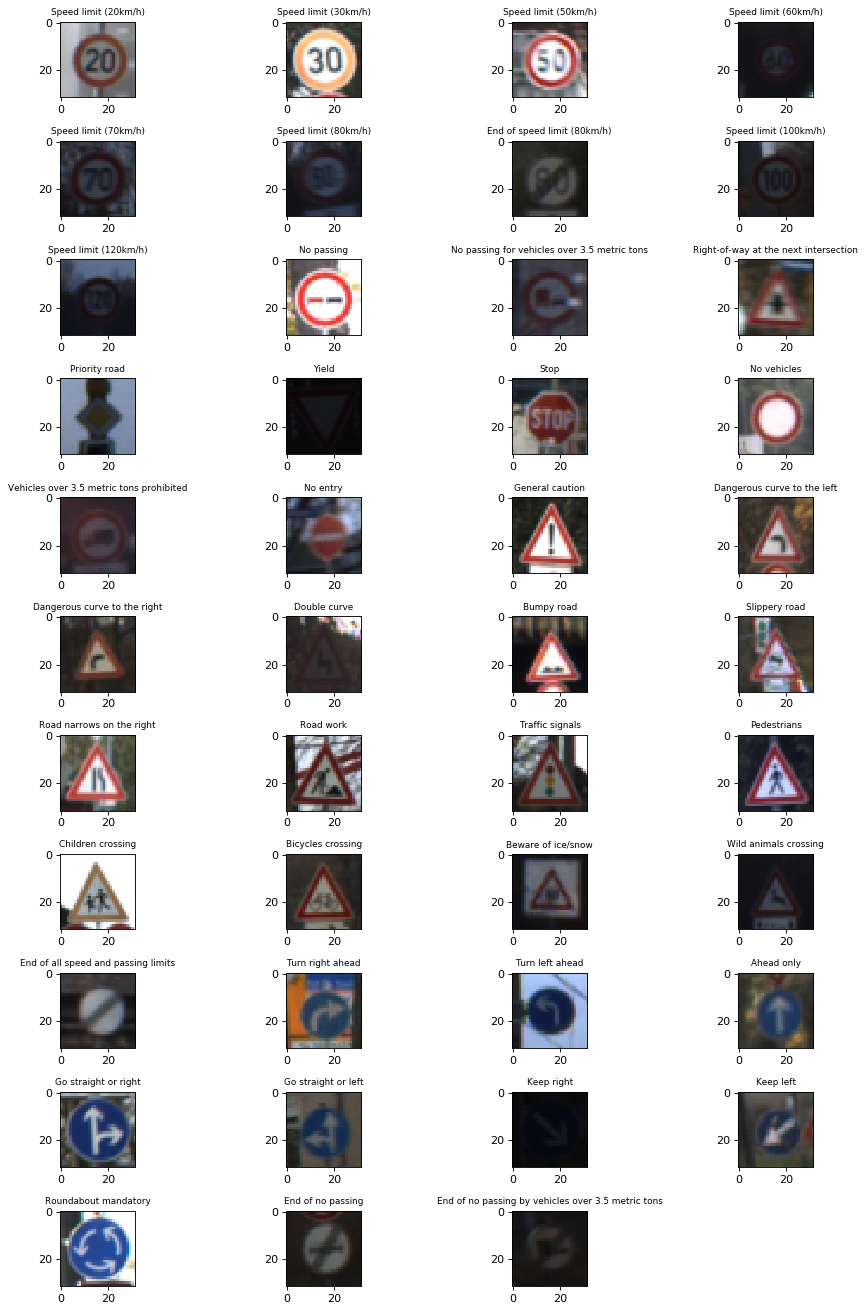

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline
def ShowSampleData(features, labels):
    labelNames = {}
    with open(signNamesFile, mode='r') as csvfile:
        csvReader = csv.reader(csvfile, delimiter=',')
        for row in csvReader:
            if row[0].isdigit():
                labelNames[int(row[0])] = row[1]
    plt.figure(figsize=(12, 16.5), dpi =80)
    for signID, signName in labelNames.items():
        plt.subplot(11, 4, 1+signID)
        selectedFeatures = features[labels == signID]
        randomize = np.random.randint(0,100)
        plt.imshow(selectedFeatures[randomize,:,:,:])
        plt.tight_layout()
        plt.title(signName, fontsize = 8)


ShowSampleData(featuresTraining, labelsTraining)
    



### Data visualization
The following code shows the data distributed over the 43 sign classes. I show a histogram for training, validation and testing data set followed by a short discussion.

training labels


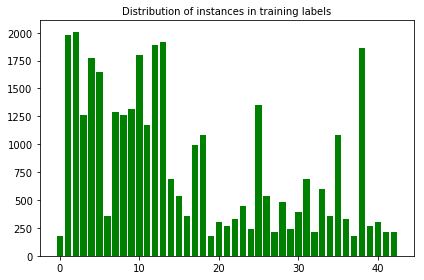

validation labels


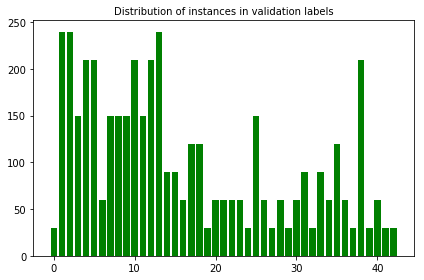

testing labels


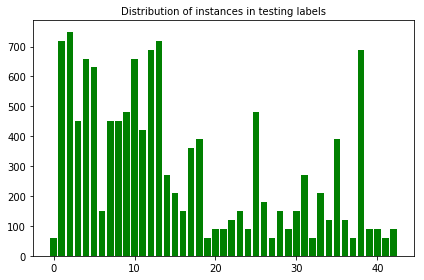

In [4]:
def DataExploration(y, name):
    result = np.unique(y, return_counts =True)
    assert(len(result[1]) == 43)
    print (name)
#    print(np.vstack((result[0], result[1])).T)
    plt.bar(result[0], result[1], 0.8, color = 'green')
    plt.title('Distribution of instances in '+name, fontsize=10)
    plt.tight_layout()
    plt.show()

    
DataExploration(labelsTraining, "training labels")
DataExploration(labelsValidation, "validation labels")
DataExploration(labelsTesting, "testing labels")


From the above histograms it is obvious that the data is far from equally distributed. This might represent the relative frequency of the traffic signs on German roads and it is no problem for validation and testing set. For particular traffic signs we have less than 200 instances in the training data set, which might be to less to train the model 
Therefore data augmentation as in [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) will be performed below.


----

##  Design and Test a Model Architecture

I follow the example in  [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). After experimenting with several different setup my final pipeline consists of three steps:
1. Data augmentation to increase sample size of underrepresented classes in the training data set
2. Data preprocessing to improve performance
3. Exploring and adjusting the LeNet model to improve performance

### Data Augmentation
At the end of Step1, we found that the data is not equally distributed and several traffic sign classes are underrepresented in the training, validation and testing set. Therefore in this section three methods (image rotation, image translation, image rescaling) are implemented which increase the number of data sets in the training data set based on the original training data set. We followed closely the suggested parameters in the baseline model and if not stated otherwise we use the following setup for data augmentation.
- Rotation was performed using a random angle between -15.0 and +15.0 degrees
- Translation was performed randomly for width/height changes in the range of -2 to +2 pixels
- Rescaling was performed for width and height using one random scaling factor between 0.8 and 1.2

For each sign instance at least 1000 sample have been required. (In an experiment 10000 samples for each sign class using an extended parameter space (rotations: -25/+25 degrees, translations: -4/+4 pixels, no rescaling) have been generated. No significant improvement of the model was observed.) The underlying images to generate the additional samples have been chosen randomely from the training data set only.

Relative frequency required for each class in whole set: 1000
Training labels after data augmentation


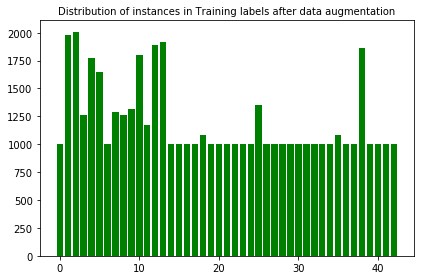

In [5]:
def ApplyImageRotation(image, angle):
    imageCenterWidth =image.shape[0]//2
    imageCenterHeight =image.shape[1]//2
    rotationMatrix = cv2.getRotationMatrix2D((imageCenterWidth, imageCenterHeight),angle,1)
    return cv2.warpAffine(image,rotationMatrix,(image.shape[0],image.shape[1]))   

def ApplyImageTranslation(image, translation):
    translationMatrix = np.float32([[1,0,translation[0]],[0,1,translation[1]]])
    return cv2.warpAffine(image,translationMatrix,(image.shape[0],image.shape[1]))

# we apply the same scaling factor to width and height to keep the square format
def ApplyImageRescaling(image, scalingFactor):
    imageWidth = image.shape[0]
    imageHeight = image.shape[1]
    newImage = cv2.resize(image,(0,0), fx=scalingFactor, fy=scalingFactor)
    newImageWidth = newImage.shape[0]
    diffWidth = imageWidth-newImageWidth
    # No scaling applied
    if(diffWidth ==0):
        newImage = image
    #New image is smaller than original, take black image and copy new image into the black one
    elif(diffWidth > 0):
        blankImage = np.zeros((imageWidth,imageHeight,3), np.uint8)
        maxOffset = diffWidth
        offsetWidth = np.random.randint(0,maxOffset)
        offsetHeight = np.random.randint(0,maxOffset)
        blankImage[offsetWidth:offsetWidth+newImageWidth, offsetHeight:offsetHeight+newImageWidth] = newImage
        newImage = blankImage
    #New image is larger than original, take a random part
    else:
        maxOffset = -diffWidth
        offsetWidth = np.random.randint(0,maxOffset)
        offsetHeight = np.random.randint(0,maxOffset)
        newImage = newImage[offsetWidth:offsetWidth+imageWidth, offsetHeight:offsetHeight+imageWidth]
    
    assert(newImage.shape == image.shape)
    return newImage



def TransformImage(image):
    angle = np.random.uniform(-15,15)
    translation = np.random.randint(-2,2,2)
    scalingFactor = np.random.uniform(0.8,1.2)
    
    rotatedImage = ApplyImageRotation(image, angle)
    translatedImage = ApplyImageTranslation(rotatedImage, translation)
    scaledImage = ApplyImageRescaling(translatedImage, scalingFactor)
    return scaledImage
      

def GenerateNewData(numberOfDataSets, underlyingImages, assignedLabel):
    generatedImageSamples = np.random.randint(len(underlyingImages), size = numberOfDataSets)
    newImages = []
    newLabels = [assignedLabel]*numberOfDataSets
    for index in generatedImageSamples:
        newImages.append(TransformImage(underlyingImages[index]))
    return newImages, newLabels



def DataAugmentation(features, labels, requiredInstancesPerSign):
    trafficSigns, trafficSignCounts = np.unique(labels, return_counts=True)
    SignsAndCounts = dict(zip(trafficSigns, trafficSignCounts))
    print( "Relative frequency required for each class in whole set: "+ repr(requiredInstancesPerSign)) 
    for signID, signCount in SignsAndCounts.items():
        if(signCount > requiredInstancesPerSign):           
            continue
        numberOfInstancesToGenerate = requiredInstancesPerSign - signCount
        featuresForNewInstanceGeneration = features[labels == signID]
        
        newImages, newLabels = GenerateNewData(numberOfInstancesToGenerate, featuresForNewInstanceGeneration,signID)
        assert(len(newLabels) == len(newImages))
        
        newImages = np.asarray(newImages, dtype=features.dtype)    
        newLabels = np.asarray(newLabels, dtype=labels.dtype)
        features = np.append(features, newImages, axis=0)
        labels = np.append(labels, newLabels, axis=0)
    return features, labels



featuresTraining, labelsTraining = DataAugmentation(featuresTraining, labelsTraining, requiredInstancesPerSign =1000)

DataExploration(labelsTraining, "Training labels after data augmentation")

In [6]:
n_train = len(labelsTraining)
# TODO: Number of validation examples
print("Number of training examples after data augmentation =", n_train)

Number of training examples after data augmentation = 51690


### Pre-process the Data Set (normalization, grayscale, etc.)

I applied three steps according to the published baseline model:
1. Switch to color space. Here I tried the HSV color space first (known from the former project) but found that the suggested    Y component from the YUV color space yields better results.
2. To improve the contrast of each image an histogram equalization was applied.
3. I normalized the data using the data sets mean and its standard deviation.

I also tried to reduce noise in the images using various functions provided by OpenCV but I did not find a significant increase of the model accuracy.

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# Extract V from HSV space (gray image)
def ConvertImageToHSVSpace(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

def ExtractV(image):
    _,_,v = cv2.split(ConvertImageToHSVSpace(image))    
    return v

# Extract Y from YUV space (gray image)
def ConvertImageToYUVSpace(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    
def ExtractY(image):
    y,_,_ = cv2.split(ConvertImageToYUVSpace(image))    
    return y

def ImageFeaturesPreProcessing(inputImages, YUV = True, imageWeight = 1.5, noiseWeight = -0.8):
    numberOfImages = inputImages.shape[0] 
    imageWidth = inputImages.shape[1] 
    imageHeight = inputImages.shape[2] 
    resultingImages = np.ndarray((numberOfImages, imageWidth, imageHeight, 1), dtype=np.uint8)
    for index, image in enumerate(inputImages):
        if(YUV):
            '''
            Use YUV color space
            '''
            image = ExtractY(image)
        else:
            '''
            Use HSV color space
            '''
            image = ExtractV(image)
        image = cv2.equalizeHist(image)
        image = np.expand_dims(image, axis=2)
        resultingImages[index] = image
    return resultingImages


# Normalize the data set
def NormalizeData(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data-mean)/std

'''
Preprocess all images
'''
featuresTraining = ImageFeaturesPreProcessing(featuresTraining)
featuresValidation = ImageFeaturesPreProcessing(featuresValidation)
featuresTesting = ImageFeaturesPreProcessing(featuresTesting)

'''
Normalize data
'''
featuresTraining = NormalizeData(featuresTraining)
featuresValidation = NormalizeData(featuresValidation)
featuresTesting = NormalizeData(featuresTesting)


### Model Architecture
In a first step I used the original LeNet architecture and made minimal adjustments regarding input shape (width, height and depth) and output depth. Using the following notation convention:
- Filter shape: (width, height, input depth, output depth)
- Input/Output shape: (width, height, input/output depth)

I used the following model in the beginning:

1. Convolution layer 1:
    - Input shape: (32,32,1)
    - Output shape:  (28,28,6)
    - Filter shape: (5, 5, 1, 6)
    - Stride shape: (1,1,1,1)
    - Pooling: Valid
2. Activation function 1: 
    - Function: Relu
    - Pooling: Valid
3. Pooling layer 1: 
    - Input shape: (28,28,6)
    - Output shape: (14,14,6)
    - Filter shape: (1,2,2,1)
    - Stride shape: (1,2,2,1)
    - Pooling: Valid
4. Convolution layer 2:
    - Input shape: (14,14,6)
    - Output shape:  (10,10,16)
    - Filter shape: (5,5,6,16)
    - Stride shape: (1,1,1,1)
    - Pooling: Valid
5. Activation function 2: 
    - Function: Relu
    - Pooling: Valid
6. Pooling layer 2:
    - Input shape: (10,10,16)
    - Output shape: (5,5,16)
    - Filter shape: (1,2,2,1)
    - Stride shape: (1,2,2,1)
    - Pooling: Valid
7. Flatten layer 1:
    - Input shape: (5,5,16)
    - Output shape: 400
8. Fully connected layer 1:
    - Input shape: 400
    - Output shape: 120
9. Activation function 3: 
    - Function: Relu
    - Pooling: Valid
10. Fully connected layer 2:
    - Input shape: 120
    - Output shape: 84
11. Activation function 4: 
    - Function: Relu
    - Pooling: Valid
12. Fully connected layer 3:
    - Input shape: 84
    - Output shape: 43



I found that these setup results in validation accurcay above 90% but not above 93 percent. I investigated some simple extensions and found the following architecture achieves a 93 % validation accurcay:

1. Convolution layer 1:
    - Input shape: (32,32,1)
    - Output shape:  (28,28,6)
    - Filter shape: (5, 5, 1, 6)
    - Stride shape: (1,1,1,1)
    - Pooling: Valid
2. Activation function 1: 
    - Function: Relu
    - Pooling: Valid
3. Pooling layer 1: 
    - Input shape: (28,28,6)
    - Output shape: (14,14,6)
    - Filter shape: (1,2,2,1)
    - Stride shape: (1,2,2,1)
    - Pooling: Valid
4. Convolution layer 2:
    - Input shape: (14,14,6)
    - Output shape:  (10,10,16)
    - Filter shape: (5,5,6,16)
    - Stride shape: (1,1,1,1)
    - Pooling: Valid
5. Activation function 2: 
    - Function: Relu
    - Pooling: Valid
6. Pooling layer 2:
    - Input shape: (10,10,16)
    - Output shape: (5,5,16)
    - Filter shape: (1,2,2,1)
    - Stride shape: (1,2,2,1)
    - Pooling: Valid
7. Flatten layer 1:
    - Input shape: (5,5,16)
    - Output shape: 400
8. Fully connected layer 1:
    - Input shape: 400
    - Output shape: 120
9. Activation function 3: 
    - Function: Relu
    - Pooling: Valid
10. Dropout function 1: 
    - Keep-Probability: 50%
11. Fully connected layer 2:
    - Input shape: 120
    - Output shape: 84
12. Activation function 4: 
    - Function: Relu
    - Pooling: Valid
13. Dropout function 2: 
    - Keep-Probability: 50%
14. Fully connected layer 3:
    - Input shape: 84
    - Output shape: 43

With this setup and the setup for data augmenation and data processing I investigated the performance of the architecture. Therefore I only altered the parameters 
- Learning rate 
- Number of epochs 
- Batch size 

The final architecture is shown in the next cell.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten
import tensorflow as tf

def LeNet(input, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
  
    weightsLayer1 = tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean = mu, stddev =sigma))
    biasLayer1 = tf.Variable(tf.zeros(6))
    paddingLayer1 = 'VALID'
    stridesLayer1 = [1,1,1,1]
    layer1 =  tf.nn.conv2d(x,weightsLayer1, stridesLayer1, paddingLayer1) + biasLayer1
    # TODO: Activation.
    activation1 = tf.nn.relu(layer1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    filterPooling1 = [1,2,2,1]
    stridesPooling1 = [1,2,2,1]
    paddingPooling1 = 'VALID'
    maxPooling1 = tf.nn.max_pool(activation1, filterPooling1, stridesPooling1, paddingPooling1)
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    weightsLayer2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean = mu, stddev =sigma))
    biasLayer2 = tf.Variable(tf.zeros(16))
    paddingLayer2 = 'VALID'
    stridesLayer2 = [1,1,1,1]
    layer2 =  tf.nn.conv2d(maxPooling1,weightsLayer2, stridesLayer2, paddingLayer2) + biasLayer2
    
    # TODO: Activation.
    activation2 = tf.nn.relu(layer2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    filterPooling2 = [1,2,2,1]
    stridesPooling2 = [1,2,2,1]
    paddingPooling2 = 'VALID'
    maxPooling2 = tf.nn.max_pool(activation2, filterPooling2, stridesPooling2, paddingPooling2)

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    flatten1 = flatten(maxPooling2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    filter3 = [400,120]
    weightsLayer3 = tf.Variable(tf.truncated_normal(filter3, mean = mu, stddev =sigma))
    biasLayer3 = tf.Variable(tf.zeros(120))
    layer3 = tf.matmul(flatten1, weightsLayer3) + biasLayer3
    
    
    # TODO: Activation.
    activation3 = tf.nn.relu(layer3)
    activation3 = tf.nn.dropout(activation3, keep_prob)
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    filter4 = [120,84]
    weightsLayer4 = tf.Variable(tf.truncated_normal(filter4, mean = mu, stddev =sigma))
    biasLayer4 = tf.Variable(tf.zeros(84))
    layer4 = tf.matmul(activation3, weightsLayer4) + biasLayer4
    
   
    # TODO: Activation.
    activation4 = tf.nn.relu(layer4)
    activation4 = tf.nn.dropout(activation4, keep_prob)
   
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    filter5 = [84,43]
    weightsLayer5 = tf.Variable(tf.truncated_normal(filter5, mean = mu, stddev =sigma))
    biasLayer5 = tf.Variable(tf.zeros(43))
    layer5 = tf.matmul(activation4, weightsLayer5) + biasLayer5
    
    return layer5


### Train, Validate and Test the Model

The following table documents the performance of the adjusted LeNet architecture varying the paramters:
- Learning rate
- Batch size
- Number of epochs

The next to last column shows the validation accuracy in the last epoch. The last column shows the maximum accuracy over all epochs and its deviation might indicate overfitting. Note, that here all other paramters are fixed (see e.g. data augmentation) to the choosen default values. It is far from obvious if a best choice for learning rate, batch size and epoch count exists in this setup. 
From the table we choose the following parameter values if not stated otherwise:

- Learning rate: 0.001
- Batch size: 128
- Number of epochs: 20



|              |           |        |                        |                 | 
|--------------|-----------|--------|------------------------|-----------------| 
| LearningRate | BatchSize | Epochs | Validation accurcay    | Maximum accuracy| 
|              |           |        |                        |                 | 
|              |           |        |                        |                 | 
| 0.001        | 128       | 20     | 97.12018141            | 97.12018141     | 
|              |           |        |                        |                 | 
| 0.001        | 64        | 20     | 96.75736957            | 97.02947841     | 
|              |           |        |                        |                 | 
| 0.001        | 256       | 20     | 95.39682537            | 95.39682537     | 
|              |           |        |                        |                 | 
| 0.001        | 32        | 20     | 96.93877555            | 96.93877555     | 
|              |           |        |                        |                 | 
| 0.0001       | 128       | 20     | 87.09750564            | 87.09750564     | 
|              |           |        |                        |                 | 
| 0.0001       | 128       | 50     | 91.06575959            | 91.3151927      | 
|              |           |        |                        |                 | 
| 0.00025      | 128       | 50     | 96.46258493            | 96.80272104     | 
|              |           |        |                        |                 | 
| 0.0005       | 128       | 50     | 96.37188211            | 97.07482993     | 
|              |           |        |                        |                 | 
| 0.0005       | 128       | 20     | 95.69160993            | 95.71428567     | 
|              |           |        |                        |                 | 
| 0.00075      | 128       | 20     | 96.28117914            | 96.28117914     | 
|              |           |        |                        |                 | 
| 0.0025       | 128       | 20     | 97.41496601            | 97.70975059     | 
|              |           |        |                        |                 | 
| 0.0025       | 64        | 15     | 97.46031739            | 97.46031739     | 
|              |           |        |                        |                 | 
| 0.005        | 128       | 10     | 95.2154195             | 95.2154195      | 
|              |           |        |                        |                 | 
| 0.005        | 128       | 15     | 94.80725626            | 94.80725626     | 
|              |           |        |                        |                 | 
| 0.0075       | 128       | 15     | 89.63718817            | 90.3174603      | 
|              |           |        |                        |                 | 
| 0.0075       | 64        | 20     | 83.15192742            | 83.15192742     | 
|              |           |        |                        |                 | 
| 0.01         | 128       | 20     | 81.70068029            | 83.60544216     | 
|              |           |        |                        |                 | 
| 0.001        | 128       | 20     | 96.05442169            | 96.16780043     | 
|              |           |        |                        |                 | 
| 0.001        | 64        | 20     | 96.23582769            | 97.00680272     | 


With the values choosen above we train, validate and finally test the model.

In [9]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
BATCH_SIZE = 128
EPOCHS = 20
learningRate = 0.001

''' Shuffle training data since training data is ordered'''
featuresTraining, labelsTraining = shuffle(featuresTraining, labelsTraining)

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, 43)


logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)    
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learningRate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


def AccuracyAnalysis(epoch, trainingAccuracy ,currentAccuracy, formerAccuracy, maximumAccuracy):
        print("EPOCH {} ...".format(epoch + 1))
        print("Training Accuracy [%] = {:.5f}".format(trainingAccuracy*100.0))
        print("Validation Accuracy [%] = {:.5f}".format(currentAccuracy*100.0))
        if(currentAccuracy > maximumAccuracy):
            maximumAccuracy = currentAccuracy

        if(formerAccuracy > 0.0):
            print("Relative change of validation accuracy [%] = {:.5f}".format((currentAccuracy - formerAccuracy)/formerAccuracy*100.0))
        if(maximumAccuracy > 0.0):
            print("Current validation accuracy in terms of maximum validation accuracy = {:.5f}".format(currentAccuracy/maximumAccuracy))
        print()
        formerAccuracy = currentAccuracy
        return formerAccuracy, maximumAccuracy
        

def evaluate(featuresData, labelsData):
    numberOfDataSets = len(featuresData)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, numberOfDataSets, BATCH_SIZE):
        batch_x, batch_y = featuresData[offset:offset + BATCH_SIZE], labelsData[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / numberOfDataSets



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    numberOfDataSets = len(featuresTraining)
    print("Training...")
    print()
    formerValidationAccuracy = 0.0
    maximumValidationAccuracy = 0.0
    for epoch in range(EPOCHS):
        featuresTraining, labelsTraining = shuffle(featuresTraining, labelsTraining)
        for offset in range(0, numberOfDataSets, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = featuresTraining[offset:end], labelsTraining[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        currentValidationAccuracy = evaluate(featuresValidation, labelsValidation)
        currentTrainingAccuracy = evaluate(featuresTraining, labelsTraining)
        
        formerValidationAccuracy, maximumValidationAccuracy = AccuracyAnalysis(epoch, currentTrainingAccuracy, currentValidationAccuracy, formerValidationAccuracy, maximumValidationAccuracy)
        
    saver.save(sess, './Model/LeNetWithDrop')
    print("Model saved")



Training...

EPOCH 1 ...
Training Accuracy [%] = 68.16986
Validation Accuracy [%] = 76.93878
Current validation accuracy in terms of maximum validation accuracy = 1.00000

EPOCH 2 ...
Training Accuracy [%] = 78.91662
Validation Accuracy [%] = 83.83220
Relative change of validation accuracy [%] = 8.95962
Current validation accuracy in terms of maximum validation accuracy = 1.00000

EPOCH 3 ...
Training Accuracy [%] = 83.53647
Validation Accuracy [%] = 87.73243
Relative change of validation accuracy [%] = 4.65242
Current validation accuracy in terms of maximum validation accuracy = 1.00000

EPOCH 4 ...
Training Accuracy [%] = 87.41343
Validation Accuracy [%] = 91.02041
Relative change of validation accuracy [%] = 3.74774
Current validation accuracy in terms of maximum validation accuracy = 1.00000

EPOCH 5 ...
Training Accuracy [%] = 89.32676
Validation Accuracy [%] = 91.47392
Relative change of validation accuracy [%] = 0.49826
Current validation accuracy in terms of maximum validation 

In [10]:
#Run testing
with tf.Session() as sess:
    saver.restore(sess, 'D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/CarND-Traffic-Sign-Classifier-Project/Model/LeNetWithDrop')
    test_accuracy = evaluate(featuresTesting, labelsTesting)
    print("Accuracy for testing = {:.5f}".format(test_accuracy))



INFO:tensorflow:Restoring parameters from D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/CarND-Traffic-Sign-Classifier-Project/Model/LeNetWithDrop
Accuracy for testing = 0.94236


---

##  Test a Model on New Images

I used Google Street View to get more pictures of traffic signs. The model, is used to 

### Load and Output the Images

In [12]:
def PredictTestImages(features, session):
    features = ImageFeaturesPreProcessing(features)
    features = NormalizeData(features)
    probabilities = sess.run(tf.nn.softmax(logits), feed_dict={x: features, keep_prob: 1.0}) 
    top5Probabilities = tf.nn.top_k(probabilities, k=5)
    predictions = sess.run(tf.argmax(logits, 1), feed_dict={x: features, keep_prob: 1.0})
    return predictions, session.run(top5Probabilities)
 

def ApplyModelToSampleImages(session):
    sampleImageFiles = [path for path in glob.glob("./Project2/CarND-Traffic-Sign-Classifier-Project/SampleSigns/*.png")]
    imageCount = len(sampleImageFiles)
    sampleImages = np.uint8(np.zeros((imageCount,32,32,3)))
    #saver.restore(session, './Project2/CarND-Traffic-Sign-Classifier-Project/Model/LeNetWithDrop')
    
    labelNames = {}
    with open(signNamesFile, mode='r') as csvfile:
        csvReader = csv.reader(csvfile, delimiter=',')
        for row in csvReader:
            if row[0].isdigit():
                labelNames[int(row[0])] = row[1]

    for index, imageFile in enumerate(sampleImageFiles):
        image=cv2.imread(imageFile)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sampleImages[index] = image
#        plt.subplot(3, 2, 1+index)
#        plt.imshow(image)
#        plt.tight_layout()
#        plt.title(index, fontsize = 8)
    predictions, top5Probabilities = PredictTestImages(sampleImages, session)
    plt.figure(figsize=(20, 22), dpi=80)
    for i in range(imageCount):
        plt.subplot(imageCount, 2, 2*i+1)
        plt.imshow(sampleImages[i]) 
        title = sampleImageFiles[i].split('\\')[-1].split('.')[0]
        title = ''.join([char for char in title if not char.isdigit()])
        title = "The correct label: " + title + " Predicted: " + labelNames[predictions[i]]
        plt.title(title, color ='red', weight = 'bold', fontsize = 8)
        plt.axis('off')
        plt.subplot(imageCount, 2, 2*i+2)
        plt.barh(np.arange(1, 6, 1), top5Probabilities.values[i, :])
        labs=[labelNames[j] for j in top5Probabilities.indices[i]]
        plt.yticks(np.arange(1, 6, 1), labs)
    plt.show()

with tf.Session() as sess:
    saver.restore(sess, 'D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/CarND-Traffic-Sign-Classifier-Project/Model/LeNetWithDrop')
    ApplyModelToSampleImages(sess)


INFO:tensorflow:Restoring parameters from D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/CarND-Traffic-Sign-Classifier-Project/Model/LeNetWithDrop


C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


InternalError: TopKOp: Could not launch cub::DeviceSegmentedRadixSort::SortPairsDescending to sort input, temp_storage_bytes: 255, status: invalid configuration argument
	 [[Node: TopKV2_1 = TopKV2[T=DT_FLOAT, sorted=true, _device="/job:localhost/replica:0/task:0/gpu:0"](TopKV2_1/input, TopKV2_1/k)]]
	 [[Node: TopKV2_1/_87 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_10_TopKV2_1", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'TopKV2_1', defined at:
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-09f9ac7f5026>", line 49, in <module>
    ApplyModelToSampleImages(sess)
  File "<ipython-input-12-09f9ac7f5026>", line 31, in ApplyModelToSampleImages
    predictions, top5Probabilities = PredictTestImages(sampleImages, session)
  File "<ipython-input-12-09f9ac7f5026>", line 5, in PredictTestImages
    top5Probabilities = tf.nn.top_k(probabilities, k=5)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1949, in top_k
    return gen_nn_ops._top_kv2(input, k=k, sorted=sorted, name=name)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 2577, in _top_kv2
    name=name)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\andre\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): TopKOp: Could not launch cub::DeviceSegmentedRadixSort::SortPairsDescending to sort input, temp_storage_bytes: 255, status: invalid configuration argument
	 [[Node: TopKV2_1 = TopKV2[T=DT_FLOAT, sorted=true, _device="/job:localhost/replica:0/task:0/gpu:0"](TopKV2_1/input, TopKV2_1/k)]]
	 [[Node: TopKV2_1/_87 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_10_TopKV2_1", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")